# PV potential from nextgems simulations - example

## Questions/challenges

* Validation: How well do PV capacity factors based on the simulations match reality?
* Trends: How does the mean PV potential change from 2020 to 2050
* Variability: How variable is the PV potential in space and time (e.g. day-to-day, month-to-month, between years)
* Extremes: How often do we have time periods with very high or very low PV potential. How long do such events last typically? Do the frequency and duration of such events change in the future?
* Energy droughts: similar as 'extremes', but for both solar and wind energy combined: what is the frequency and typical duration of events with very low capacity factor for both PV and wind energy?

### Load modules and some functions

In [1]:
# 1) Uncomment below to install the hackathon python environment (only needed once). 
# 2) After installing, refresh the jupyter browser and select as kernel the newly installed one (click on top-right, look for python-HH-hackathon)
# 3) You can then comment this line again
#!module use /work/k20200/k202134/hsm-tools/outtake/module; module load python3/hamburg-hackathon; python -m ipykernel install --name python-HH-hackathon --user


In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import healpy as hp
import intake
import dask
import gribscan
import eccodes
import numcodecs


from dask.distributed import Client
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import cfgrib
"""
from cdo import *
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import shutil, os
import scipy 
"""
def attach_coords(ds):
    lons, lats = hp.pix2ang(
        get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True
    )
    lons = np.where(lons>180, lons-360, lons)
    
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degree_north"}),
        lon=(("cell",), lons, {"units": "degree_east"}),
    )

def get_nest(ds):
    return ds.crs.healpix_order == "nest"

def get_nside(ds):
    return ds.crs.healpix_nside

cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")


## Extracting simulation data (optional)
See below for an example on how to extract (and save to netcdf) timeseries of radiation, surface temperature, and precipitation from the Cycle4 IFS and ICON simulations, for a single location. 
This takes a a few minutes for the 3hour ICON data and about two hours for the 1h IFS data.
To save some time, the timeseries have already be processed, so **running the code below is not necessary.**

### 3h ICON data at zoom level 9 (using 15 min data is preferred, but requires more time and memory)


In [52]:
icon = cat.ICON['ngc4008'](zoom=9, time='PT15M', chunks="auto").to_dask() # zoom ranges from 1 to 10, time options are 'PT15M', 'PT3H','1D' (15 min, 3hours, daily)
icon = attach_coords(icon)
icon

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/tmp/ipykernel_294547/1332250513.py:26: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True


<xarray.Dataset> Size: 79TB
Dimensions:  (crs: 1, time: 1051968, cell: 3145728)
Coordinates:
  * crs      (crs) float32 4B nan
  * time     (time) datetime64[ns] 8MB 2020-01-01T00:15:00 ... 2050-01-01
    lat      (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (cell) float64 25MB 45.0 45.09 44.91 45.0 ... -44.91 -45.09 -45.0
Dimensions without coordinates: cell
Data variables:
    pr       (time, cell) float32 13TB dask.array<chunksize=(576, 49152), meta=np.ndarray>
    qv2m     (time, cell) float32 13TB dask.array<chunksize=(576, 49152), meta=np.ndarray>
    rlut     (time, cell) float32 13TB dask.array<chunksize=(576, 49152), meta=np.ndarray>
    rsds     (time, cell) float32 13TB dask.array<chunksize=(576, 49152), meta=np.ndarray>
    sfcwind  (time, cell) float32 13TB dask.array<chunksize=(576, 49152), meta=np.ndarray>
    tas      (time, cell) float32 13TB dask.array<chunksize=(576, 49152), meta=np.ndarray>

### 1h IFS data zoom level 9

In [4]:
# extracting time series from the 2D_hourly_healpix512, containing the full 30 years, often crashes when processing timeseries of accumulated variables such as radiation or precipitations,
# hence the somewhhat ugly approach below

ifs = xr.concat([cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_2020s'](chunks={}).to_dask(),
                 cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_2030s'](chunks={}).to_dask(),
                 cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_2040s'](chunks={}).to_dask()], dim='time')
                 
ifs['lon'] = xr.where(ifs.lon < 180, ifs.lon, ifs.lon-360)
ifs

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in or

<xarray.Dataset> Size: 377TB
Dimensions:  (time: 262566, value: 3145728)
Coordinates:
    lat      (value) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (value) float64 25MB 45.0 45.09 44.91 45.0 ... -44.91 -45.09 -45.0
  * time     (time) datetime64[ns] 2MB 2020-01-20 ... 2050-01-01
Dimensions without coordinates: value
Data variables: (12/57)
    10u      (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    10v      (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    2d       (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    2t       (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    blh      (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    chnk     (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    ...       ...
    tp       (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    tprate   (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    tsr      (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    tsrc     (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    ttr      (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    ttrc     (time, value) float64 7TB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

### Select healpix cell containing the city of Wageningen and select relevant variables

In [16]:
lat_wag = 51.98
lon_wag = 5.66

idx_wag = hp.ang2pix(get_nside(icon), lon_wag, lat_wag, nest=get_nest(icon), lonlat=True)

icon_wag = icon.isel(cell=idx_wag)[['tas','rsds', 'pr']]
ifs_wag = ifs.isel(value=idx_wag)[['2t','ssrd','tp']]

icon_wag.to_netcdf("/work/bb1153/b382003/hackathon-wageningen/simulation_data/ICON_wageningen.nc")
ifs_wag.to_netcdf("/work/bb1153/b382003/hackathon-wageningen/simulation_data/IFS_wageningen.nc")


In [89]:
lat_wag = 51.98
lon_wag = 5.66

icon = cat.ICON['ngc4008'](zoom=7, time='P1D', chunks="auto").to_dask() # zoom ranges from 1 to 10, time options are 'PT15M', 'PT3H','1D' (15 min, 3hours, daily)
icon = attach_coords(icon)

icon_pr_yr = icon[['crs','pr']].sel(time=slice("2020","2049")).groupby('time.year').sum().mean(dim='year') * 86400

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/tmp/ipykernel_294547/1332250513.py:26: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True


In [94]:
icon.pr

<xarray.DataArray 'pr' (time: 10958, cell: 196608)> Size: 9GB
dask.array<open_dataset-pr, shape=(10958, 196608), dtype=float32, chunksize=(180, 98304), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 88kB 2020-01-02 2020-01-03 ... 2050-01-01
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... -44.65 -45.35 -45.0
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface

## Loading timeseries data

### Read from file and make variables names and units consistent (for convenience later on)

In [2]:
icon_wag = xr.open_dataset("/work/bb1153/b382003/hackathon-wageningen/simulation_data/ICON_wageningen.nc").sel(time=slice("2020","2049")).rename({"tas":"T2", "rsds":"swd"})
ifs_wag = xr.open_dataset("/work/bb1153/b382003/hackathon-wageningen/simulation_data/IFS_wageningen.nc").sel(time=slice("2020","2049")).rename({"2t":"T2", "ssrd":"swd", "tp":"pr"})

# icon's precip is in kg/m2/s, ifs' precip in m (accumulated). Convert both to mm, accumulated between time steps
icon_wag['pr'] *= 3600 * 3 # mm
icon_wag['pr'].attrs['units'] = 'mm'

ifs_wag['pr'] *= 1e3 # m to mm
ifs_wag['pr'].attrs['units'] = 'mm'

# ifs' radiation is accumulated (J/m2), convert to W/m2
ifs_wag['swd'] /= 3600
ifs_wag['swd'].attrs['units'] = "W m-2"

### Quicklook: yearly averaged shortwave irradiance, 2m temperature and precipitation

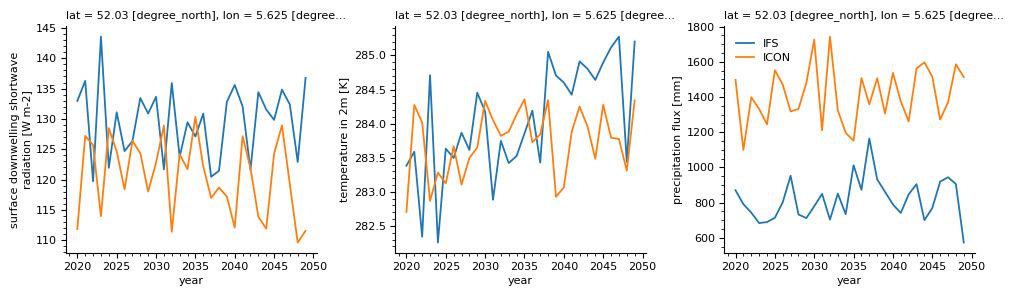

In [3]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
ifs_wag.swd.groupby('time.year').mean().plot(ax=axes[0], label='IFS')
icon_wag.swd.groupby('time.year').mean().plot(ax=axes[0], label='ICON')

ifs_wag.T2.groupby('time.year').mean().plot(ax=axes[1], label='IFS')
icon_wag.T2.groupby('time.year').mean().plot(ax=axes[1], label='ICON')

ifs_wag.pr.groupby('time.year').sum().plot(ax=axes[2], label='IFS')
icon_wag.pr.groupby('time.year').sum().plot(ax=axes[2], label='ICON')

plt.legend()
plt.tight_layout()


## Calculating PV potential (capacity factors)
### Small bit of theory
The power output of a PV system can be described as the product of the installed capacity, i.e. the rated power $PV_\mathrm{STC}$ under standard testing conditions ($T_\mathrm{PV,STC}$=25$\degree$C cell temperature, $G_\mathrm{STC}$=1000 W m$^{-2}$ solar irradiance on the panel), and a PV potential or capacity factor $CF$ that (mostly) depends on meteorological conditions:
$$PV_\mathrm{yield} = CF*PV_\mathrm{STC}$$
Since we do not have information on $PV_\mathrm{STC}$ for every single PV panel, we focus on calculating capacity factors. The capacity factor can be expressed as
$$CF = \eta \dfrac{G}{G_\mathrm{STC}},$$
where $G$ is the solar irradiance on the panel and $\eta$ is an efficiency factor accounting for the changes in panel efficiency with cell temperature. Multiple expressions exist for the cell temperature as function of meteorological conditions, such as solar irradiance, ambient temperature and (sometimes) wind speed, as well es for panel efficiency as function of cell temperature, but for simplicity we just select a single expression for both in the examples below. $G$ depends mostly on the global horizontal irradiance at the surface, and in the examples below we simply use $G=GHI$, optionally with some losses due to soiling (dust accumulation on PV panels in long periods with precipitation). However, for more accuracy we may also want to account for PV panel tilt (which requires direct/diffuse partition of the radiance, which is not available and thus has to be estimated), reflections from the ground on tilted panels, and shading by adjacent panels.

#### some literature:
https://doi.org/10.1016/j.renene.2015.10.006
https://doi.org/10.1016/j.apenergy.2020.116239
https://doi.org/10.1038/s41893-020-00643-w


### Functions
Many PV related functions, including (some of) the functions, are also available in the python package PVlib

In [4]:
# following https://www.sciencedirect.com/science/article/pii/S0960148115303591#appsecA
def cell_temperature(T, G):  
    Ta = T - 273.15
    Tnoct = 45 # degrees celcius 
    T0 = 20 # degree C
    G0 = 800 #W/m2
    return Ta + (Tnoct - T0) * G/G0
    
# e.g. https://www.nature.com/articles/s41893-020-00643-w#Sec4
def efficiency(Tpv, G):
    beta = 0.005
    Tstc = 25 # degree C
    return 1 - beta*(Tpv-Tstc)

def capacity_factor(eta, G):
    Gstc = 1000 # W/m2
    return eta * G/Gstc

In [5]:
Tpv_icon = cell_temperature(icon_wag.T2, icon_wag.swd)
eta_icon = efficiency(Tpv_icon, icon_wag.swd)
cf_icon = capacity_factor(eta_icon, icon_wag.swd)

Tpv_ifs = cell_temperature(ifs_wag.T2, ifs_wag.swd)
eta_ifs = efficiency(Tpv_ifs, ifs_wag.swd)
cf_ifs = capacity_factor(eta_ifs, ifs_wag.swd)

### Plotting time series of monthly mean capacity factors

/home/b/b382003/.local/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/home/b/b382003/.local/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


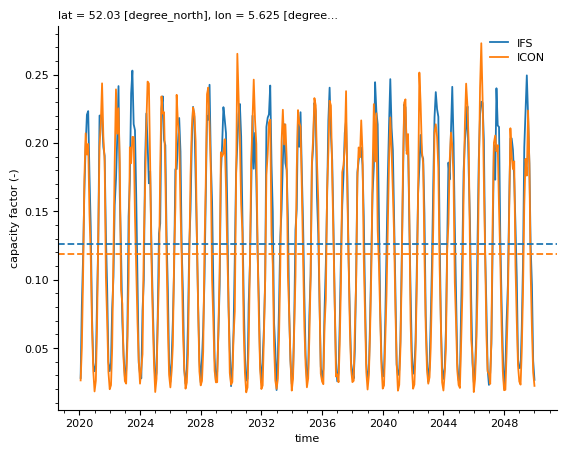

In [6]:
cf_ifs.resample(time='1M').mean().plot(label='IFS', c="C0")
cf_icon.resample(time='1M').mean().plot(label='ICON', c="C1")
plt.axhline(cf_ifs.mean(), c="C0",ls="--")
plt.axhline(cf_icon.mean(), c="C1",ls="--")
plt.legend()
plt.ylabel('capacity factor (-)')
plt.show()

IFS is a bit more optimistic than ICON, giving on average about 5% more PV yield!

### Soiling
last, let's have a look at the impact of soiling, which is the impact of dust accumulations. Also for soiling, multiple models exist. As an example, we use the Kimber soiling model (http://dx.doi.org/10.1109/WCPEC.2006.279690), which is solely based on precipitations. The model assumes a constant accumulation of dust when there is no precipitation, a complete removal of dust when daily mean precipitation exceeds a certain threshold, and a 14 day period after each rainfall event without dust accumulation. The function below is taken from PVlib, but adapted for use with xarray instead of pandas.

In [7]:
def kimber(rainfall, cleaning_threshold=6, soiling_loss_rate=0.0015,
           grace_period=14, max_soiling=0.3, initial_soiling=0, rain_accum_period=24):

    nanfall = np.isnan(rainfall)

    rainfall = rainfall.where(~np.isnan(rainfall), 0)

    # convert grace_period (days) and rain_accum_period (hour) to multiples of time resolution
    timestep_interval = rainfall.time[1] - rainfall.time[0]

    rain_accum_period = int(rain_accum_period / (timestep_interval / np.timedelta64(1,'h')))

    grace_period = int(grace_period / (timestep_interval / np.timedelta64(1,'D')))

    # Convert timestep to fraction of days
    day_fraction = timestep_interval / np.timedelta64(24, 'h')

    # accumulate rainfall, xarray rolling cannot handle float64 apparently
    accumulated_rainfall = rainfall.astype(np.float64).rolling(
            time=rain_accum_period, min_periods=1).sum()

    # soiling rate
    soiling = rainfall.copy(deep=True, data = np.ones(rainfall.shape, dtype=np.float64) * soiling_loss_rate * day_fraction.values)
    soiling.loc[dict(time=soiling.time[0])] = initial_soiling
    soiling = soiling.cumsum(dim='time')
    soiling.name = 'soiling'

    # rainfall events that clean the panels
    rain_events = accumulated_rainfall > cleaning_threshold

    # grace periods windows during which ground is assumed damp, so no soiling
    grace_windows = rain_events.rolling(time=grace_period, min_periods=1).sum() > 0

    # clean panels by subtracting soiling for indices in grace period windows
    cleaning = rainfall.copy(deep=True, data = xr.where(grace_windows, soiling, np.nan))
    cleaning.loc[dict(time=soiling.time[0])] = 0.0

    # remove soiling by foward filling cleaning where NaN
    soiling -= cleaning.ffill(dim='time')

    # check if soiling has reached the maximum
    soiling = soiling.where(soiling < max_soiling, max_soiling)
    return soiling.where(~nanfall, np.nan)


In [8]:
soiling_ifs = kimber(ifs_wag.pr)
cf_ifs_soiled = cf_ifs * (1-soiling_ifs)

soiling_icon = kimber(icon_wag.pr)
cf_icon_soiled = cf_icon * (1-soiling_icon)

print("mean soiling IFS:  {:.3f} %".format(soiling_ifs.mean()*1e2))
print("mean soiling ICON: {:.3f} %".format(soiling_icon.mean()*1e2))

mean soiling IFS:  0.331 %
mean soiling ICON: 0.087 %


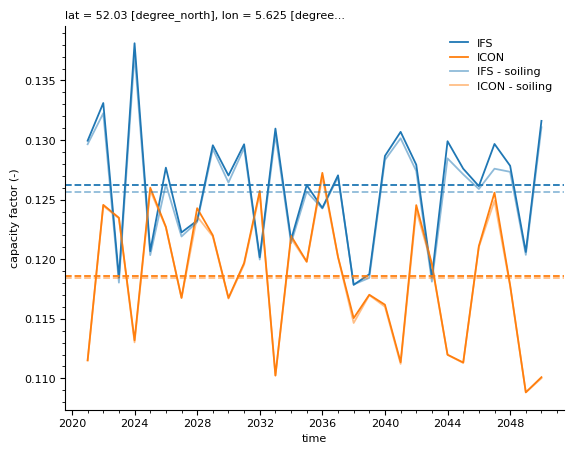

In [9]:
cf_ifs.resample(time='1YE').mean().plot(label='IFS', c="C0")
cf_icon.resample(time='1YE').mean().plot(label='ICON', c="C1")
cf_ifs_soiled.resample(time='1YE').mean().plot(label='IFS - soiling', c="C0", alpha=.5)
cf_icon_soiled.resample(time='1YE').mean().plot(label='ICON - soiling', c="C1", alpha=.5)
plt.axhline(cf_ifs.mean(), c="C0", ls="--")
plt.axhline(cf_icon.mean(), c="C1", ls="--")
plt.axhline(cf_ifs_soiled.mean(), c="C0",ls="--", alpha=.5)
plt.axhline(cf_icon_soiled.mean(), c="C1",ls="--", alpha=.5)
plt.legend()
plt.ylabel('capacity factor (-)')
plt.show()

Quite a lot of precipitation in the Netherlands, hence hardly any soiling losses, especially in ICON). In drier climates, however, soiling losses can be much more significant. 